In [21]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

import pdcast as pdc

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

import mscproject.features as feats
import mscproject.preprocess as pre
import mscproject.pygloaders as pgl
from mscproject.metrics import EvalMetrics
import catboost as cb

In [22]:
# Read config.
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

features_path = conf_dict["features_path"]

In [23]:
# Load features for data split.
def load_features(path_root):
    companies_df = pd.read_parquet(conf_dict["companies_features"])
    persons_df = pd.read_parquet(conf_dict["persons_features"])
    return companies_df, persons_df

In [24]:
companies_df, persons_df = load_features(features_path)

In [42]:
companies_df.describe().T

,count,mean,std,min,25%,50%,75%,max
component,96530.0,2.053295e+03,2.260015e+03,0.000000,6.000000,1134.500000,3986.000000,6863.000000
indegree,96530.0,1.396809e+00,6.632770e-01,0.000000,1.000000,1.000000,2.000000,19.000000
outdegree,96530.0,5.657930e-01,3.065651e+00,0.000000,0.000000,0.000000,0.000000,460.000000
closeness,96530.0,1.350720e-05,5.956061e-06,0.000000,0.000008,0.000014,0.000015,0.000147
clustering,96530.0,4.972611e-03,4.416499e-02,0.000000,0.000000,0.000000,0.000000,1.000000
pagerank,96530.0,8.559665e-06,3.628377e-06,0.000005,0.000006,0.000007,0.000010,0.000087
neighbourhood_count,96530.0,1.356905e+00,2.944190e+00,1.000000,1.000000,1.000000,1.000000,460.000000
neighbourhood_indegree_min,96530.0,1.391951e+00,6.445426e-01,1.000000,1.000000,1.000000,2.000000,15.000000
neighbourhood_outdegree_min,96530.0,7.269243e-02,8.008565e-01,0.000000,0.000000,0.000000,0.000000,105.000000
neighbourhood_closeness_min,96530.0,1.434386e-05,6.195291e-06,0.000000,0.000010,0.000014,0.000016,0.000116


In [26]:
common_cols = set(companies_df.columns) & set(persons_df.columns)
drop_cols = ["id", "name", "component"]
select_cols = sorted(common_cols.difference(drop_cols))

target = "is_anomalous"

entities_df = pd.concat([companies_df, persons_df], axis=0)[list(common_cols)]

In [27]:
masks = pgl.get_data_split_masks(entities_df)

In [28]:
train_df = entities_df.loc[list(masks.train.numpy())].drop(drop_cols, axis=1)
valid_df = entities_df.loc[list(masks.val.numpy())].drop(drop_cols, axis=1)
test_df = entities_df.loc[list(masks.test.numpy())].drop(drop_cols, axis=1)

In [29]:
train_df

,neighbourhood_closeness_std,neighbourhood_outdegree_max,neighbourhood_outdegree_std,neighbourhood_indegree_std,neighbourhood_clustering_max,pagerank,neighbourhood_clustering_mean,indegree,outdegree,neighbourhood_outdegree_min,...,neighbourhood_count,neighbourhood_clustering_sum,neighbourhood_outdegree_sum,neighbourhood_pagerank_std,neighbourhood_pagerank_max,neighbourhood_indegree_mean,is_anomalous,neighbourhood_indegree_max,neighbourhood_closeness_sum,neighbourhood_clustering_std
0,0.000000,0.0,0.0,0.0,0.0,0.000006,0.0,1,1,0.0,...,1.0,0.0,0.0,0.000000e+00,0.000011,2.0,False,2.0,0.000021,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000007,0.0,1,0,0.0,...,1.0,0.0,0.0,0.000000e+00,0.000007,1.0,False,1.0,0.000010,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000006,0.0,1,0,0.0,...,1.0,0.0,0.0,0.000000e+00,0.000006,1.0,False,1.0,0.000008,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000010,0.0,2,0,0.0,...,1.0,0.0,0.0,0.000000e+00,0.000010,2.0,False,2.0,0.000015,0.0
4,0.000005,0.0,0.0,0.5,0.0,0.000011,0.0,2,2,0.0,...,2.0,0.0,0.0,1.336300e-06,0.000015,2.5,False,3.0,0.000051,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32604,0.000000,1.0,0.0,0.0,0.0,0.000005,0.0,0,1,1.0,...,1.0,0.0,1.0,0.000000e+00,0.000015,3.0,False,3.0,0.000023,0.0
32605,0.000000,0.0,0.0,0.0,0.0,0.000005,0.0,0,1,0.0,...,1.0,0.0,0.0,0.000000e+00,0.000011,2.0,False,2.0,0.000015,0.0
32606,0.000000,0.0,0.0,0.0,0.0,0.000005,0.0,0,1,0.0,...,1.0,0.0,0.0,0.000000e+00,0.000010,1.0,True,1.0,0.000008,0.0
32607,0.000000,6.0,0.0,0.0,0.0,0.000005,0.0,0,1,6.0,...,1.0,0.0,6.0,0.000000e+00,0.000010,1.0,False,1.0,0.000008,0.0


In [30]:
train_df.query("isCompany == False and indegree > 0")

,neighbourhood_closeness_std,neighbourhood_outdegree_max,neighbourhood_outdegree_std,neighbourhood_indegree_std,neighbourhood_clustering_max,pagerank,neighbourhood_clustering_mean,indegree,outdegree,neighbourhood_outdegree_min,...,neighbourhood_count,neighbourhood_clustering_sum,neighbourhood_outdegree_sum,neighbourhood_pagerank_std,neighbourhood_pagerank_max,neighbourhood_indegree_mean,is_anomalous,neighbourhood_indegree_max,neighbourhood_closeness_sum,neighbourhood_clustering_std


In [31]:
# Create train, test, and valid pools for CatBoost.

cat_features = ["isCompany"]

X_train = train_df.drop(target, axis=1)
y_train = train_df[target].astype(np.int8)

X_valid = valid_df.drop(target, axis=1)
y_valid = valid_df[target].astype(np.int8)

X_test = test_df.drop(target, axis=1)
y_test = test_df[target].astype(np.int8)

In [32]:
train_pool = cb.Pool(
    X_train.to_numpy(),
    y_train.to_numpy(),
    cat_features=cat_features,
    feature_names=X_train.columns.to_list(),
)

valid_pool = cb.Pool(
    X_valid.to_numpy(),
    y_valid.to_numpy(),
    cat_features=cat_features,
    feature_names=X_valid.columns.to_list(),
)

test_pool = cb.Pool(
    X_test.to_numpy(),
    y_test.to_numpy(),
    cat_features=cat_features,
    feature_names=X_test.columns.to_list(),
)

In [33]:
class_weights = {0: 1, 1: 10}

In [34]:
# Create CatBoost model.
clf = cb.CatBoostClassifier(
    iterations=2001,
    # learning_rate=0.1,
    depth=6,
    # eval_metric="Accuracy",
    class_weights=class_weights,
    random_seed=42,
    loss_function="Logloss",
    eval_metric="PRAUC",
)


# Fit model.
clf.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    verbose=200,
)

Learning rate set to 0.075363
0:	learn: 0.6850474	test: 0.6328043	best: 0.6328043 (0)	total: 12.3ms	remaining: 24.5s
200:	learn: 0.7372597	test: 0.6614576	best: 0.6616806 (186)	total: 3.31s	remaining: 29.6s
400:	learn: 0.7617603	test: 0.6676245	best: 0.6683330 (391)	total: 6.87s	remaining: 27.4s
600:	learn: 0.7776665	test: 0.6719456	best: 0.6730888 (579)	total: 10.3s	remaining: 24.1s
800:	learn: 0.7892371	test: 0.6687684	best: 0.6730888 (579)	total: 13.6s	remaining: 20.4s
1000:	learn: 0.7979298	test: 0.6680362	best: 0.6730888 (579)	total: 17.1s	remaining: 17.1s
1200:	learn: 0.8054204	test: 0.6697706	best: 0.6730888 (579)	total: 20.5s	remaining: 13.7s
1400:	learn: 0.8117124	test: 0.6703893	best: 0.6730888 (579)	total: 23.9s	remaining: 10.2s
1600:	learn: 0.8172984	test: 0.6705929	best: 0.6730888 (579)	total: 27.2s	remaining: 6.8s
1800:	learn: 0.8219966	test: 0.6709444	best: 0.6730888 (579)	total: 30.6s	remaining: 3.39s
2000:	learn: 0.8259946	test: 0.6710343	best: 0.6730888 (579)	total: 3

In [35]:
# Print confusion matrix.
y_pred = clf.predict(test_pool)
print(pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]))

Predicted     0     1
Actual               
0          2830  4483
1           100   601


In [36]:
# Evaluate model.
y_test_pred = np.array([x[1] for x in clf.predict_proba(test_pool)])
eval_metrics = EvalMetrics.from_numpy(y_test_pred, y_test.to_numpy())
print(eval_metrics)

loss: 0.619, acc: 0.913, prc: 0.118, rec: 0.857, f1: 0.208, auc: 0.674, aprc: 0.272


In [37]:
# Get Shapley values.
shap_values = clf.get_feature_importance(test_pool, type="ShapValues")[:, 1:]


import shap

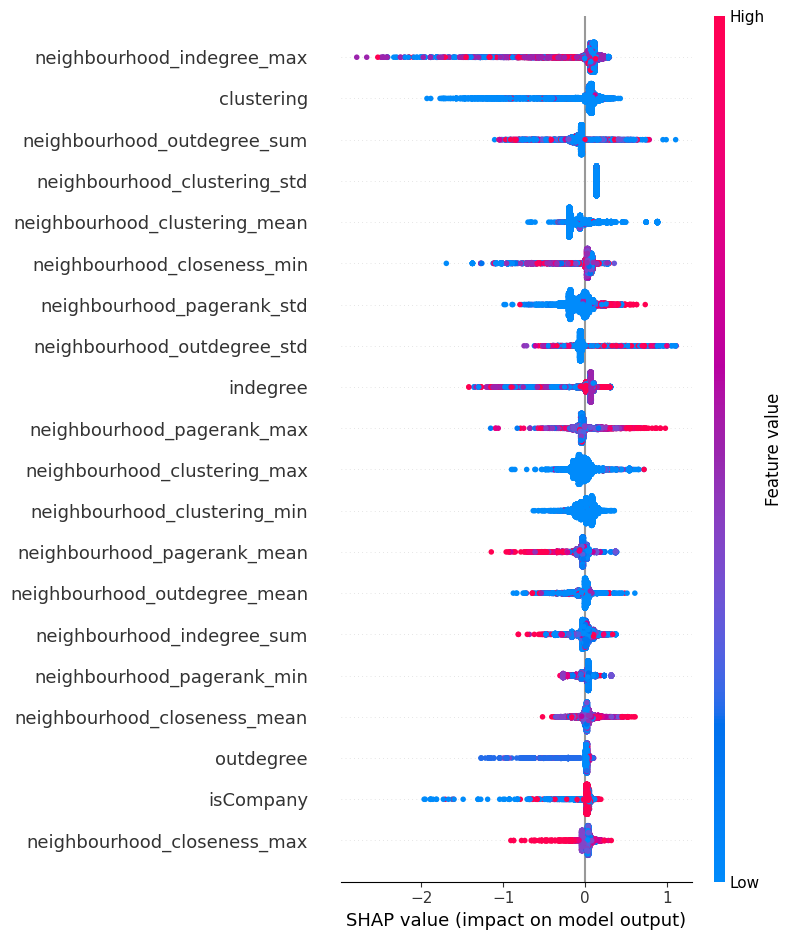

In [38]:
shap.summary_plot(shap_values, X_test)

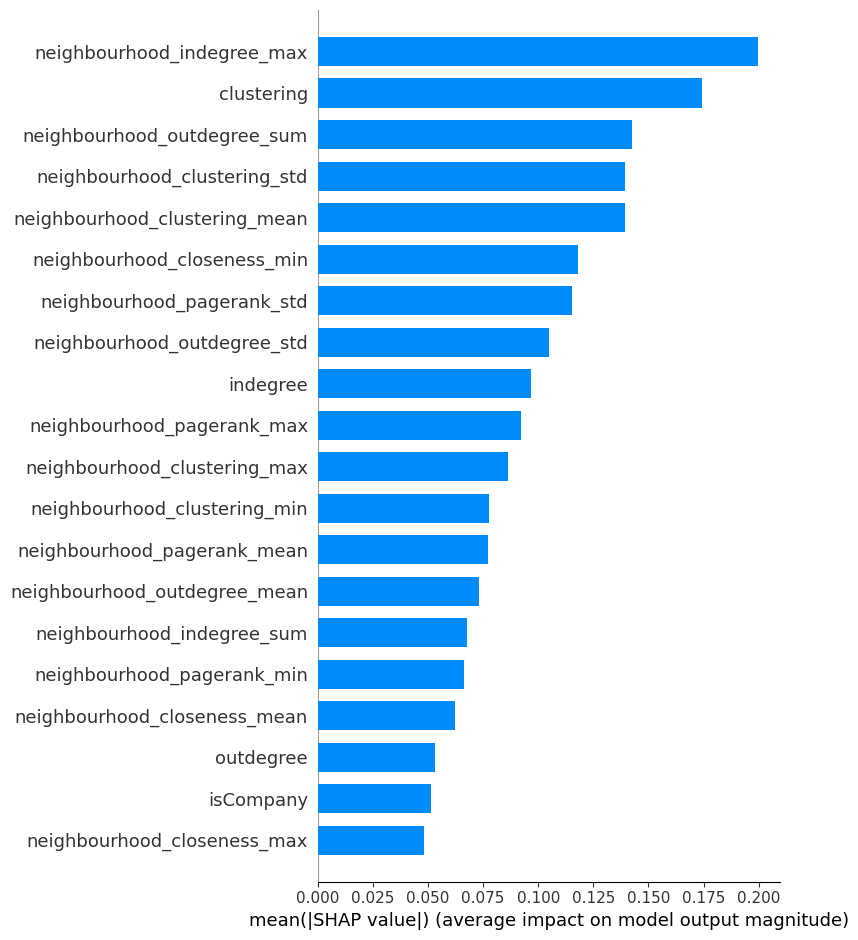

In [39]:
# Plot partial dependence plots.
shap.summary_plot(shap_values, X_test, plot_type="bar")

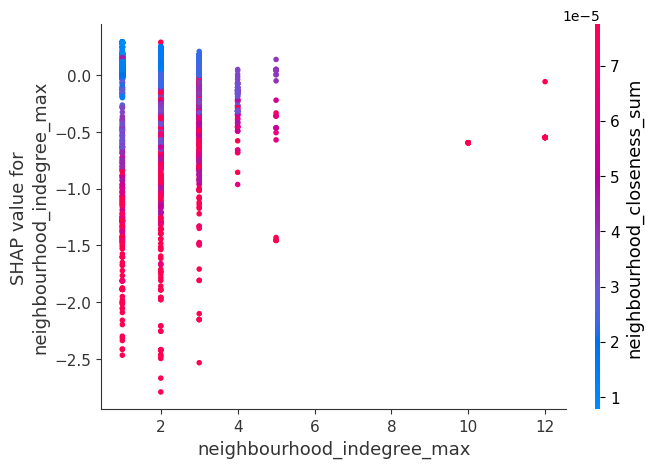

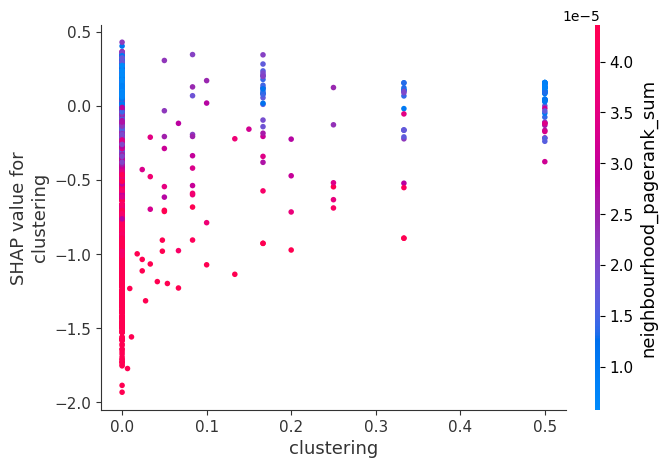

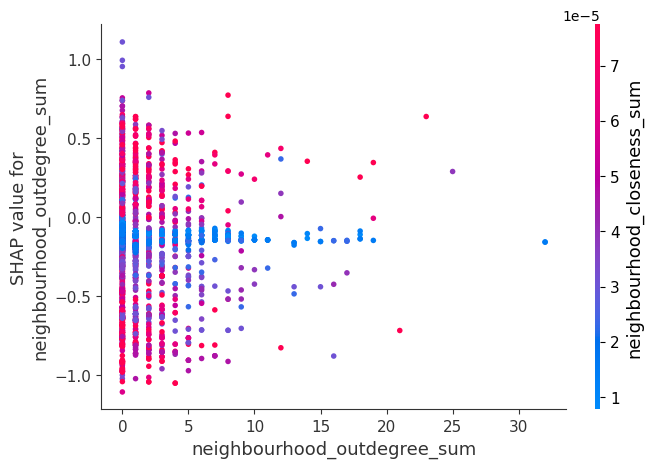

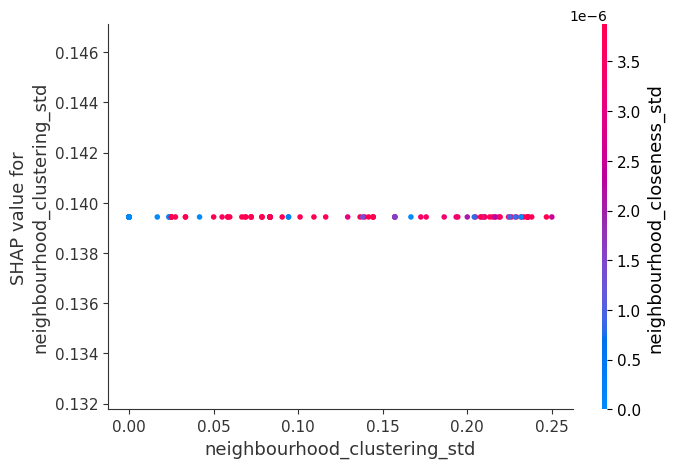

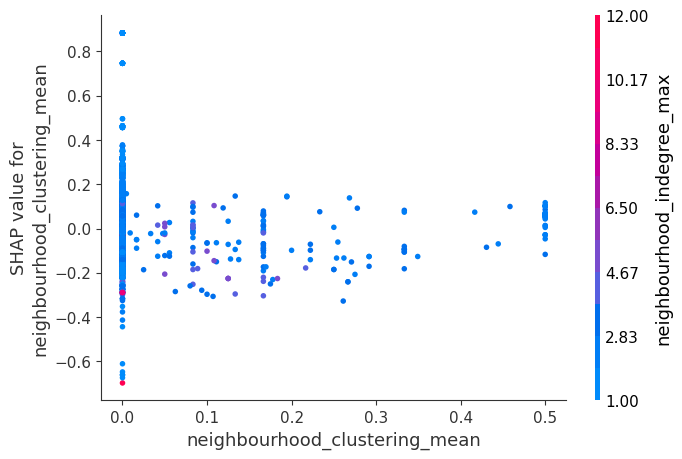

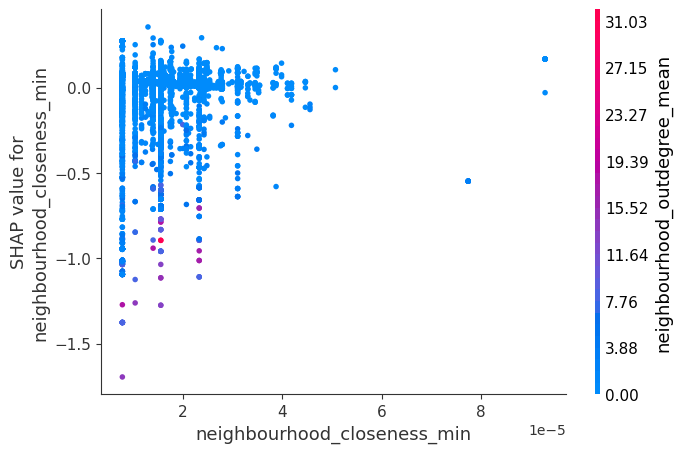

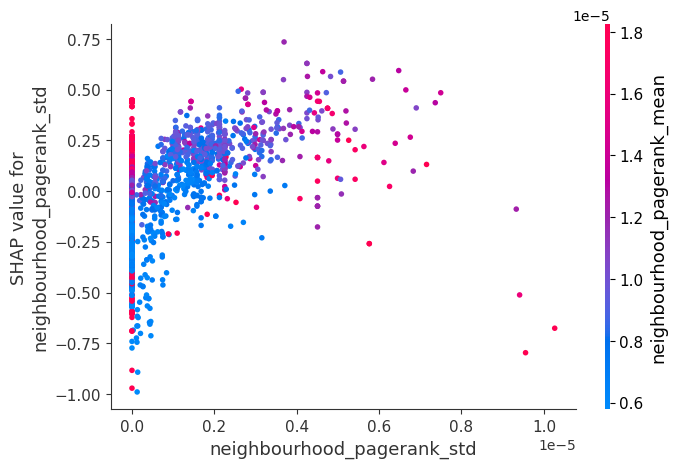

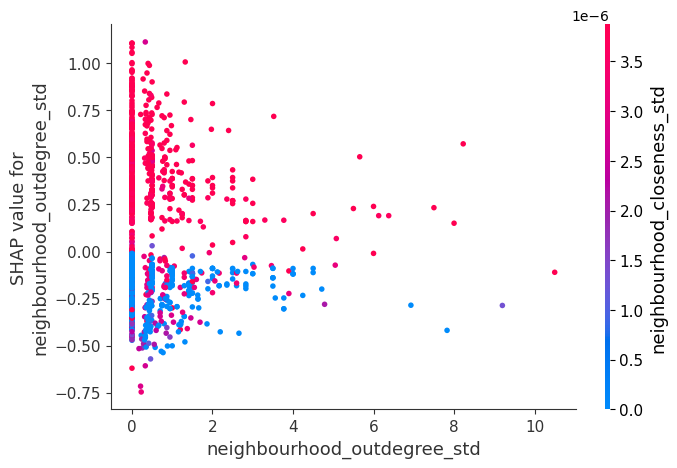

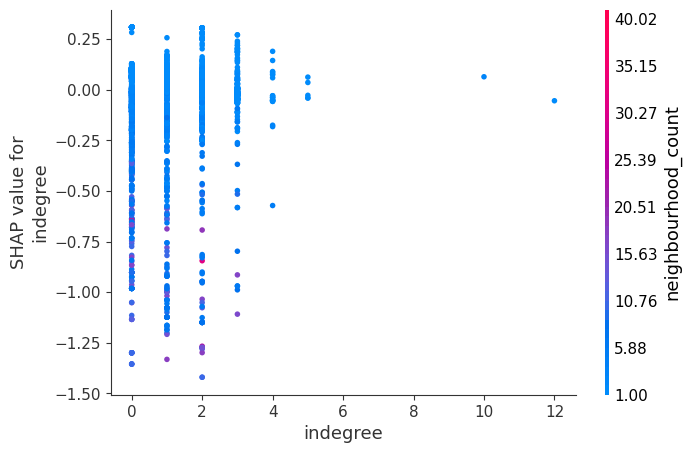

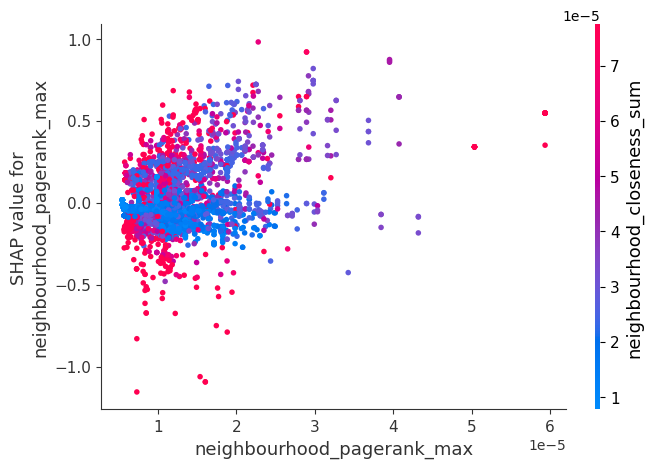

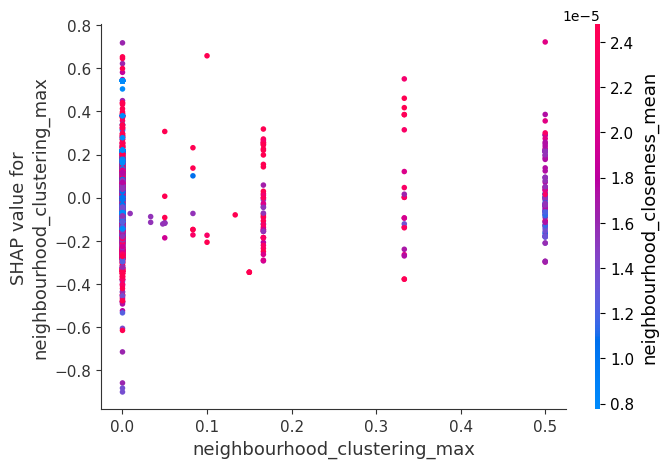

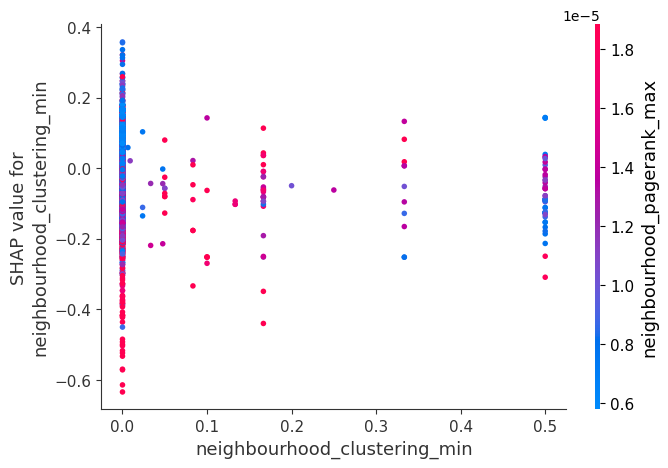

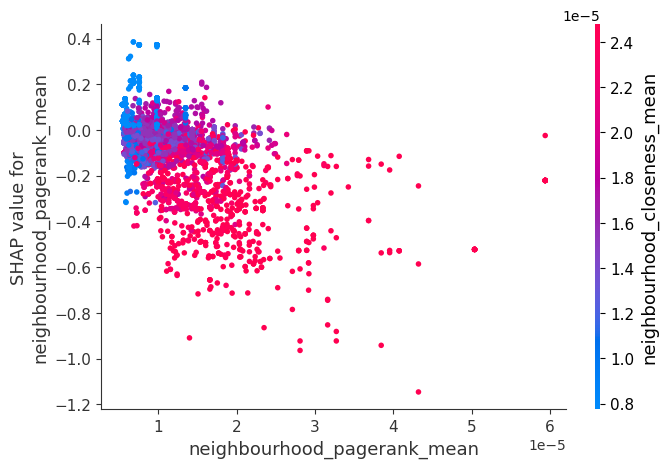

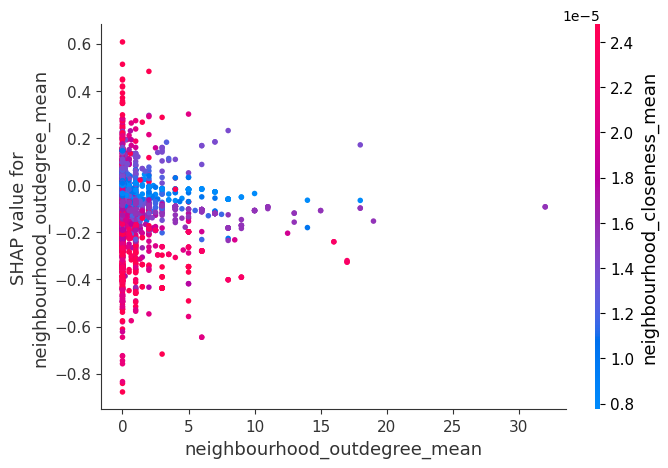

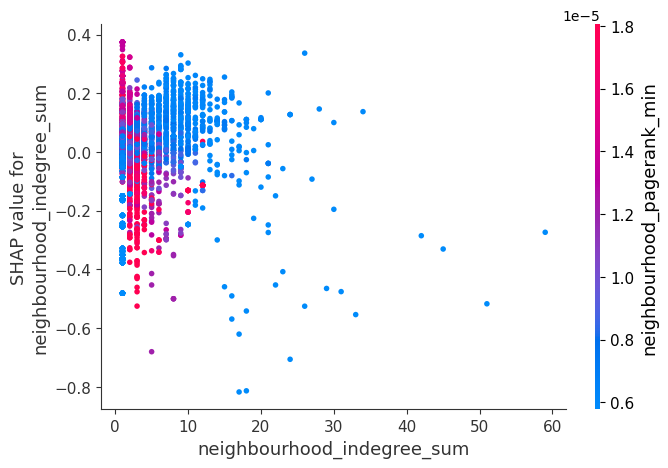

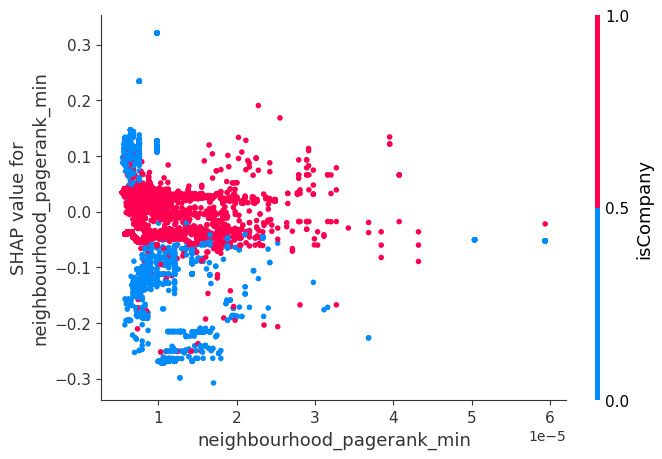

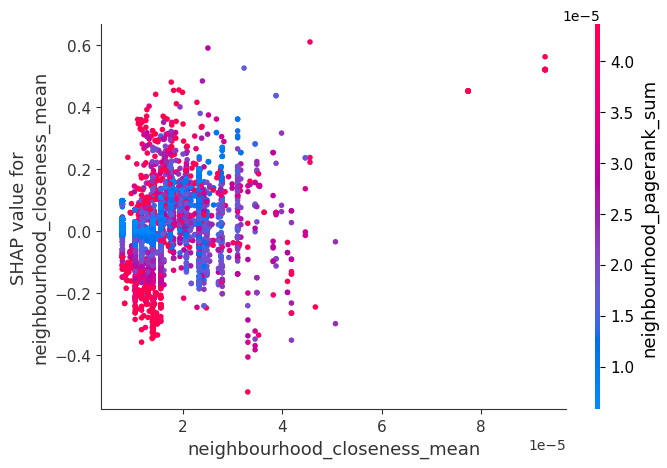

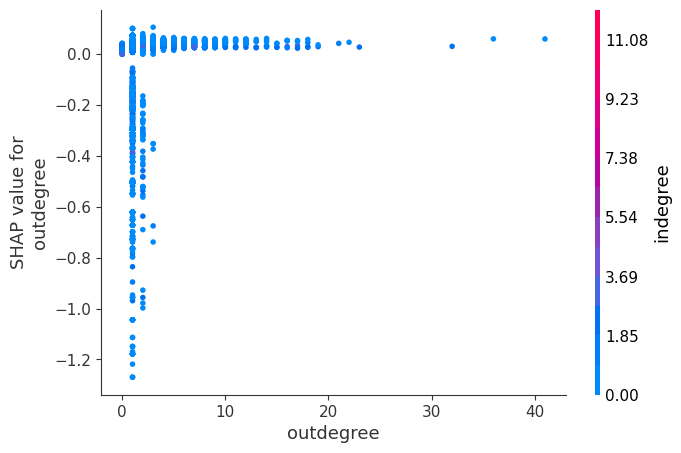

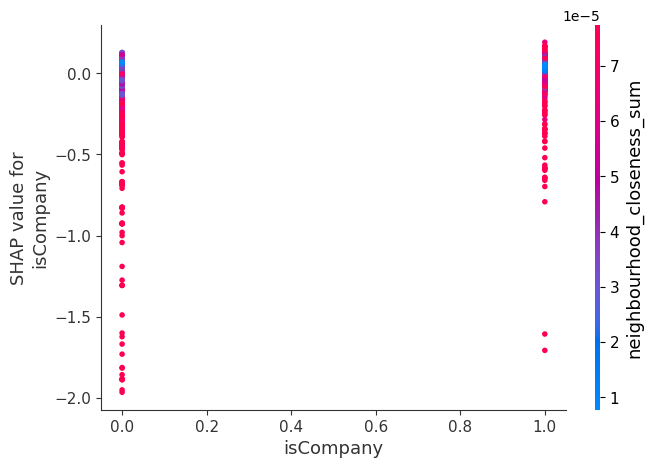

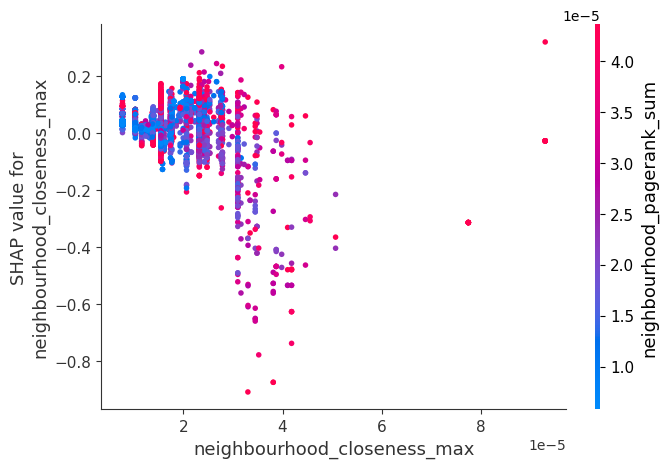

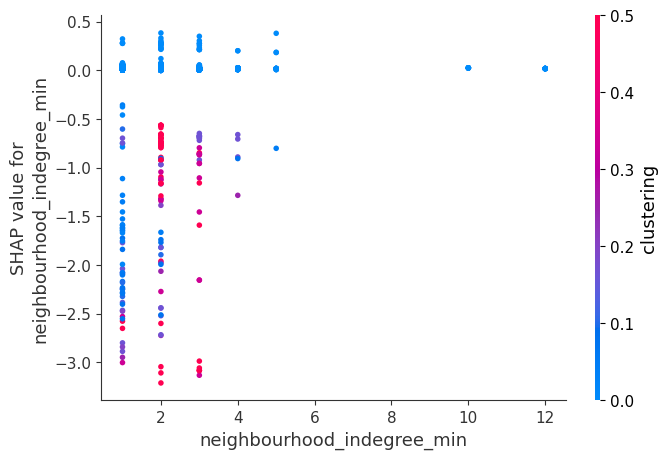

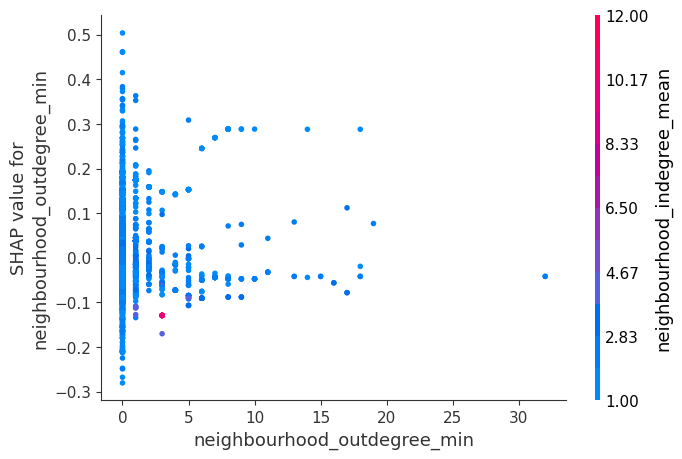

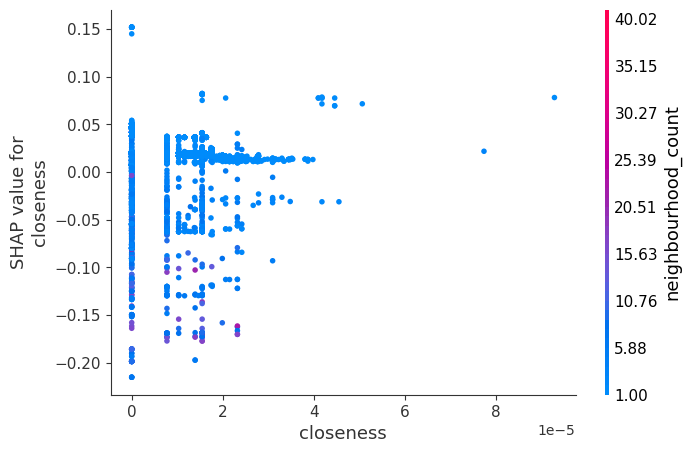

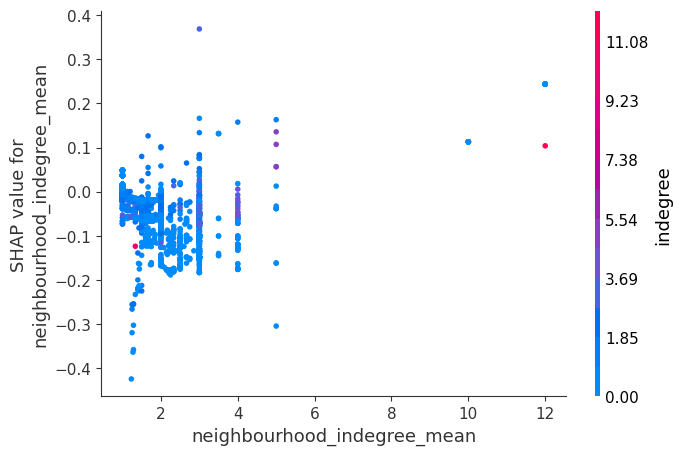

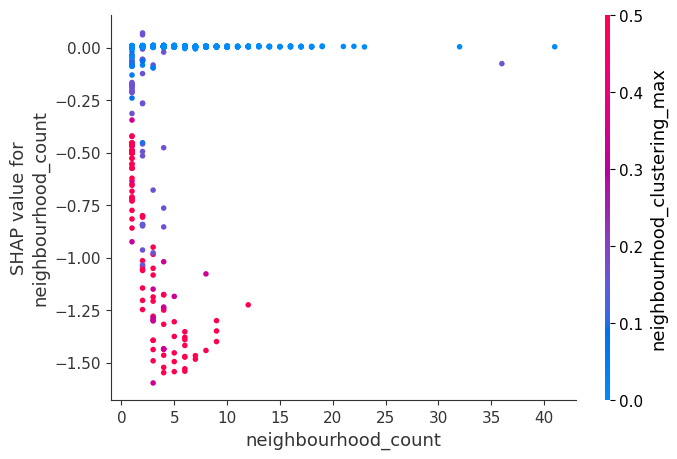

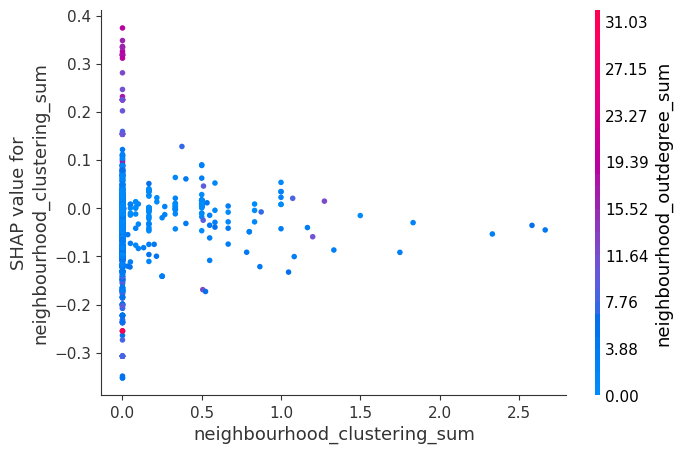

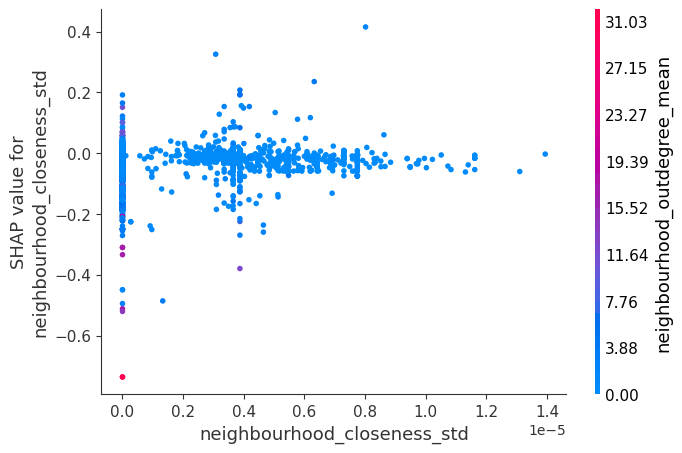

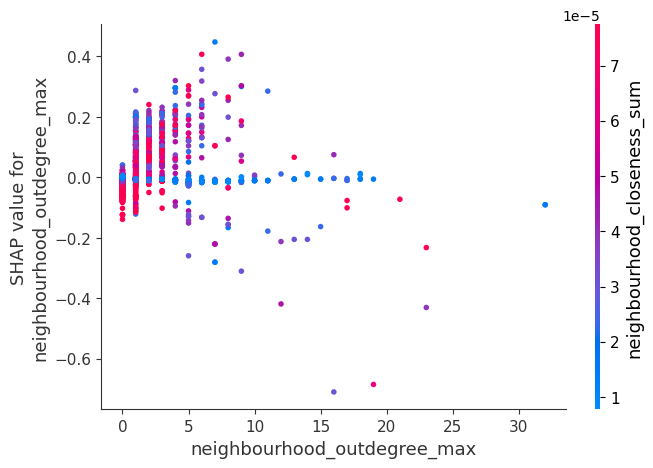

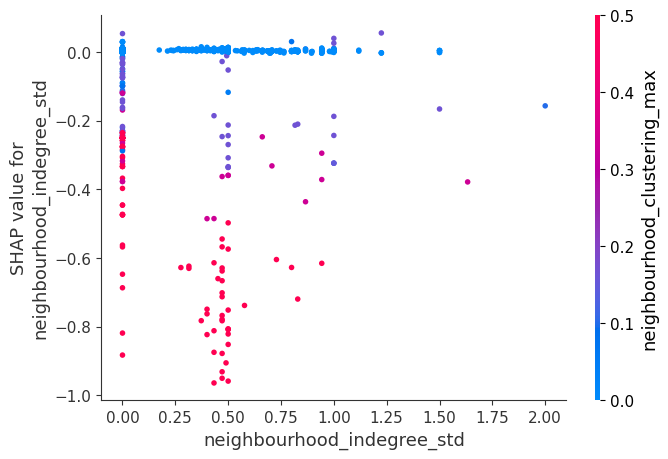

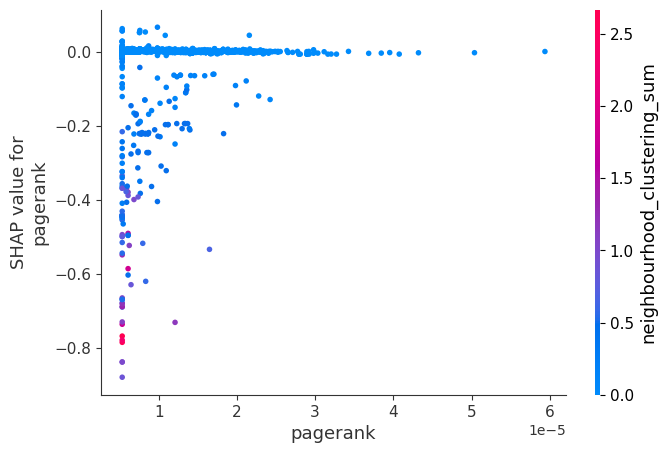

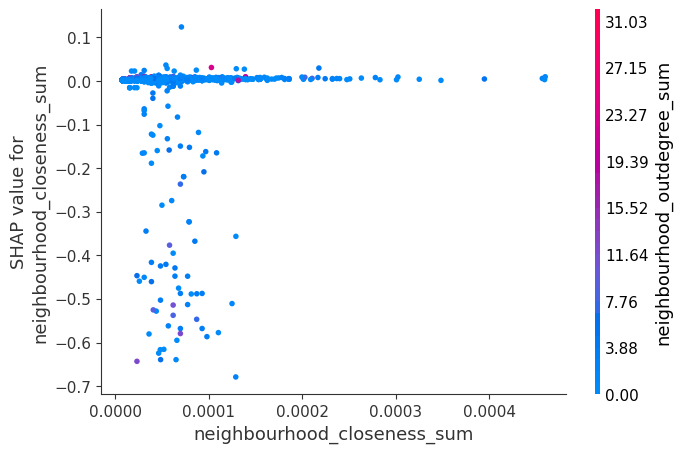

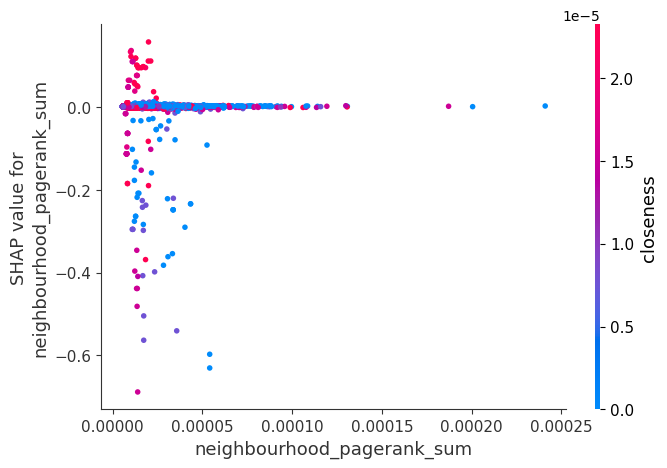

In [40]:
for i in range(X_test.shape[1]):
    shap.dependence_plot(f"rank({i})", shap_values, X_test)
    plt.show()